# Phase One

### Analysis using presets from tutorial 4 from bingo documentation 

### Goal: Given input data and output data, find the functional form of the equation

### Import Training Data
Explicit regression is being used during this phase, data is imported here from the output of output_data

In [137]:
%reset -f
import numpy as np
import pandas as pd

from bingo.symbolic_regression import ExplicitTrainingData

#filepath and name
file = "/Users/clarissaseebohm/Desktop/ME EN 5510/Project/cs-ap/data/training_data/training_data.csv"

#read csv using pandas so that data has type DataFrame
df_ = pd.read_csv(file)
df_ = df_.drop(labels=6, axis=0)
df = df_.sort_values(by='Radius', axis=0)

x = df['Radius'].to_numpy().reshape([-1, 1])
y = df['MaxStress'].to_numpy()

training_data = ExplicitTrainingData(x, y)

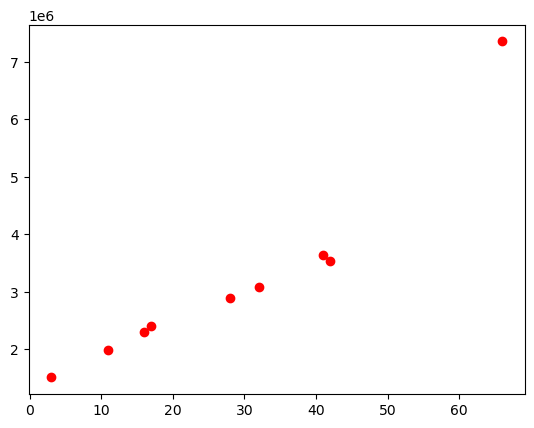

In [138]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.plot(training_data.x, training_data.y, 'ro')
plt.show()

### AGraph Component Generator
Initialize AGraph components and add mathematical operators

In [139]:
from bingo.symbolic_regression import ComponentGenerator

component_generator = ComponentGenerator(input_x_dimension=x.shape[1])
component_generator.add_operator("+")
component_generator.add_operator("-")
component_generator.add_operator("*")

### AGraph Generator
Use the component generator to generate AGraphChromosome individuals. The size is the maximum number of operators allowed within your equation, more operators is more precise, but also more time consuming and computationally intense

In [140]:
from bingo.symbolic_regression import AGraphGenerator

agraph_generator = AGraphGenerator(agraph_size=20, 
                                   component_generator=component_generator)

In [141]:
agraph = agraph_generator()
print("f(X_0) = ", agraph)

f(X_0) =  X_0 - ((X_0)(X_0)) - (X_0 - ((X_0)(X_0)))


### AGraph Variation

In [142]:
from bingo.symbolic_regression import AGraphCrossover
from bingo.symbolic_regression import AGraphMutation

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)

### Evaluation: Explicit Regression

In [143]:
from bingo.symbolic_regression import ExplicitRegression
from bingo.local_optimizers.scipy_optimizer import ScipyOptimizer
from bingo.local_optimizers.local_opt_fitness import LocalOptFitnessFunction
from bingo.evaluation.evaluation import Evaluation

fitness = ExplicitRegression(training_data=training_data)
optimizer = ScipyOptimizer(fitness, method='lm')
local_opt_fitness = LocalOptFitnessFunction(fitness, optimizer)
evaluator = Evaluation(local_opt_fitness)

In [144]:
np.random.seed(16)
agraph = agraph_generator()
print("Before local optimization: f(X_0) = ", agraph)
print("                          fitness = ", fitness(agraph))
_ = local_opt_fitness(agraph)
print("After local optimization:  f(X_0) = ", agraph)
print("                          fitness = ", fitness(agraph))

Before local optimization: f(X_0) =  X_0 + 1.0
                          fitness =  3189611.6666666665
After local optimization:  f(X_0) =  X_0 + 3189612.6666666665
                          fitness =  1102040.6666666667


Evaluate Agraphs at x

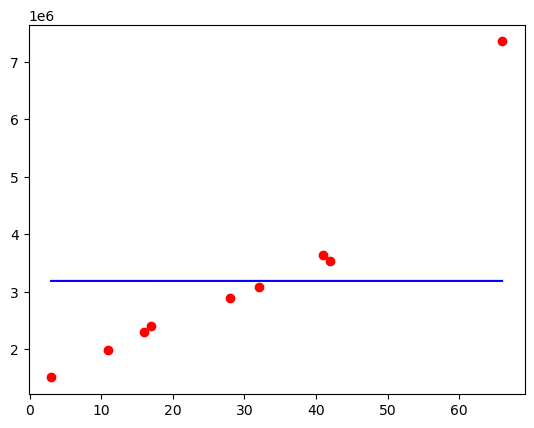

In [145]:
agraph_y = agraph.evaluate_equation_at(training_data.x)

plt.plot(training_data.x, training_data.y, 'ro')
plt.plot(training_data.x, agraph_y, 'b-')
plt.show()

### Age Fitness Evolutionary Algorithm

Age Fitness EA is used to combat premature convergence that can be seen in symbolic regression

In [146]:
from bingo.evolutionary_algorithms.age_fitness import AgeFitnessEA

POPULATION_SIZE = 500
MUTATION_PROBABILITY = 0.4
CROSSOVER_PROBABILITY = 0.4

ea = AgeFitnessEA(evaluator, agraph_generator, crossover, mutation, 
                  CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, POPULATION_SIZE)

### Pareto Front

In [147]:
from bingo.stats.pareto_front import ParetoFront

def agraph_similarity(ag_1, ag_2):
    """a similarity metric between agraphs"""
    return ag_1.fitness == ag_2.fitness and ag_1.get_complexity() == ag_2.get_complexity()

pareto_front = ParetoFront(secondary_key=lambda ag: ag.get_complexity(),
                           similarity_function=agraph_similarity) 

### Evolution on an island

In [148]:
from bingo.evolutionary_optimizers.island import Island
np.random.seed(5)

island = Island(ea, agraph_generator, POPULATION_SIZE, hall_of_fame=pareto_front)
print("Best individual\n f(X_0) =", island.get_best_individual())

Best individual
 f(X_0) = (X_0 + X_0)(51769.42201478024 + X_0 + X_0)


Run until convergence. Print the best result. We store each best individual in a list and use this to observe how the best solution evolves over time.

In [149]:
ERROR_TOLERANCE = 1E-3

best_indv_values = []
best_indv_values.append(island.get_best_individual())
best_indv_gen = []
best_indv_gen.append(island.generational_age)

while island.get_best_fitness() > ERROR_TOLERANCE:
    island.evolve(1)
    best_indv = island.get_best_individual()
    if best_indv.fitness < best_indv_values[-1].fitness:
        best_indv_values.append(best_indv)
        best_indv_gen.append(island.generational_age)
    if(island.generational_age > 500):
        break

print("Generation: ", island.generational_age)
print("Success!")
print("Best individual\n f(X_0) =", island.get_best_individual())

Generation:  5001
Success!
Best individual
 f(X_0) = ((X_0)(35.17732596338704))((X_0)(35.17732596338704)) + 1775654.8036889907


here, we can see the tradeoff between fitness and complexity

In [150]:
print(" FITNESS   COMPLEXITY    EQUATION")
for member in pareto_front:
    print("%.3e     " % member.fitness, member.get_complexity(),
          "     f(X_0) =", member)

 FITNESS   COMPLEXITY    EQUATION
2.034e+05      6      f(X_0) = ((X_0)(35.17732596338704))((X_0)(35.17732596338704)) + 1775654.8036889907
2.898e+05      5      f(X_0) = (1237.4442597043062 + (X_0)(X_0))(1237.4442597043062)
5.942e+05      4      f(X_0) = (101386.63674224896)(X_0) + 101386.63674224896
6.131e+05      3      f(X_0) = (X_0)(103683.4157915208)
1.046e+06      2      f(X_0) = (1700.3862548184916)(1700.3862548184916)
1.083e+06      1      f(X_0) = 2551467.664302597


### Animation of evolution

In [151]:
def animate_data(list_of_best_indv, list_of_best_gens, training_data):

    fig, ax = plt.subplots()
    
    num_frames = len(list_of_best_indv)
    
    x = training_data.x
    y_actually = training_data.y
    y = list_of_best_indv
    g = list_of_best_gens
    plt.plot(training_data.x, training_data.y, 'ro')
    points, = ax.plot(x, y[0].evaluate_equation_at(x), 'b')
    points.set_label('Generation :' + str(g[0]))
    legend = ax.legend(loc='upper right', shadow=True)


    def animate(i):
        ax.collections.clear()
        points.set_ydata(y[i].evaluate_equation_at(x))  # update the data
        points.set_label('Generation :' + str(g[i]))
        legend = ax.legend(loc='upper right')
        return points, legend


    # Init only required for blitting to give a clean slate.
    def init():
        points.set_ydata(np.ma.array(x, mask=True))
        return points, points

    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.title("Best Individual in Island", fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    plt.close()

    return animation.FuncAnimation(fig, animate, num_frames, init_func=init,
                                interval=250, blit=True)

In [152]:
from IPython.display import HTML
anim2 = animate_data(best_indv_values, best_indv_gen, training_data)
HTML(anim2.to_jshtml())